#Download do dataset e importação das libs

In [ ]:
import kagglehub
import shutil

dataset_path = kagglehub.dataset_download("suprematism/daily-minimum-temperatures")

shutil.move(dataset_path, "/content/daily-minimum-temperatures.csv")

print("Dataset salvo em: /content/daily-minimum-temperatures.csv")

100%|██████████| 13.7k/13.7k [00:00<00:00, 24.9MB/s]

Extracting files...
Dataset salvo em: /content/daily-minimum-temperatures.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

#Pré-Processamento


In [ ]:
# 1. Carregamento do dataset
df = pd.read_csv('/content/daily-minimum-temperatures.csv/1_Daily_minimum_temps.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print("Cabeçalho do dataset:")
print(df.head())

# 2. Pré-processamento: Normalização dos dados
df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce') # 'coerce' converts invalid values to NaN

# Drop rows with NaN values in 'Temp'
df.dropna(subset=['Temp'], inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
df['Temp_scaled'] = scaler.fit_transform(df[['Temp']])

<ipython-input-3-a24da43a057d>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


Cabeçalho do dataset:
            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8


#Criação do Input da RNN

In [ ]:
# 3. Criação das sequências para a RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 7  # janela de 7 dias para predição
data = df['Temp_scaled'].values
X, y = create_sequences(data, seq_length)

In [ ]:
# Divisão em treino e teste (80% treino, 20% teste)
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# Converter para tensores do PyTorch e ajustar dimensões: (batch, seq_length, features)
X_train_tensor = torch.from_numpy(X_train).float().unsqueeze(-1)
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(-1)
X_test_tensor = torch.from_numpy(X_test).float().unsqueeze(-1)
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(-1)


#Modelo RNN

In [ ]:
# 4. Definição do modelo RNN com LSTM
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        # Utiliza a saída do último time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out


In [ ]:
# Configurações do modelo
input_size = 1
hidden_size = 50
num_layers = 1
output_size = 1

model = RNNModel(input_size, hidden_size, num_layers, output_size)

In [ ]:
# 5. Treinamento do modelo
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 500

train_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Época [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Época [10/500], Loss: 0.0272
Época [20/500], Loss: 0.0203
Época [30/500], Loss: 0.0163
Época [40/500], Loss: 0.0119
Época [50/500], Loss: 0.0107
Época [60/500], Loss: 0.0105
Época [70/500], Loss: 0.0101
Época [80/500], Loss: 0.0100
Época [90/500], Loss: 0.0098
Época [100/500], Loss: 0.0097
Época [110/500], Loss: 0.0095
Época [120/500], Loss: 0.0094
Época [130/500], Loss: 0.0092
Época [140/500], Loss: 0.0091
Época [150/500], Loss: 0.0090
Época [160/500], Loss: 0.0090
Época [170/500], Loss: 0.0090
Época [180/500], Loss: 0.0090
Época [190/500], Loss: 0.0090
Época [200/500], Loss: 0.0090
Época [210/500], Loss: 0.0090
Época [220/500], Loss: 0.0090
Época [230/500], Loss: 0.0089
Época [240/500], Loss: 0.0089
Época [250/500], Loss: 0.0089
Época [260/500], Loss: 0.0089
Época [270/500], Loss: 0.0089
Época [280/500], Loss: 0.0089
Época [290/500], Loss: 0.0090
Época [300/500], Loss: 0.0089
Época [310/500], Loss: 0.0090
Época [320/500], Loss: 0.0089
Época [330/500], Loss: 0.0089
Época [340/500], Lo

#Avaliação do Modelo

In [ ]:
# 6. Avaliação e cálculo do RMSE
model.eval()
with torch.no_grad():
    train_pred = model(X_train_tensor)
    test_pred = model(X_test_tensor)

# Converter para numpy e reverter a escala
train_pred = scaler.inverse_transform(train_pred.numpy())
y_train_actual = scaler.inverse_transform(y_train_tensor.numpy())
test_pred = scaler.inverse_transform(test_pred.numpy())
y_test_actual = scaler.inverse_transform(y_test_tensor.numpy())

# Calcular RMSE para treino e teste
train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_pred))
test_rmse = math.sqrt(mean_squared_error(y_test_actual, test_pred))
print(f'RMSE Treino: {train_rmse:.4f}')
print(f'RMSE Teste: {test_rmse:.4f}')


RMSE Treino: 2.4695
RMSE Teste: 2.2148


#Visualização

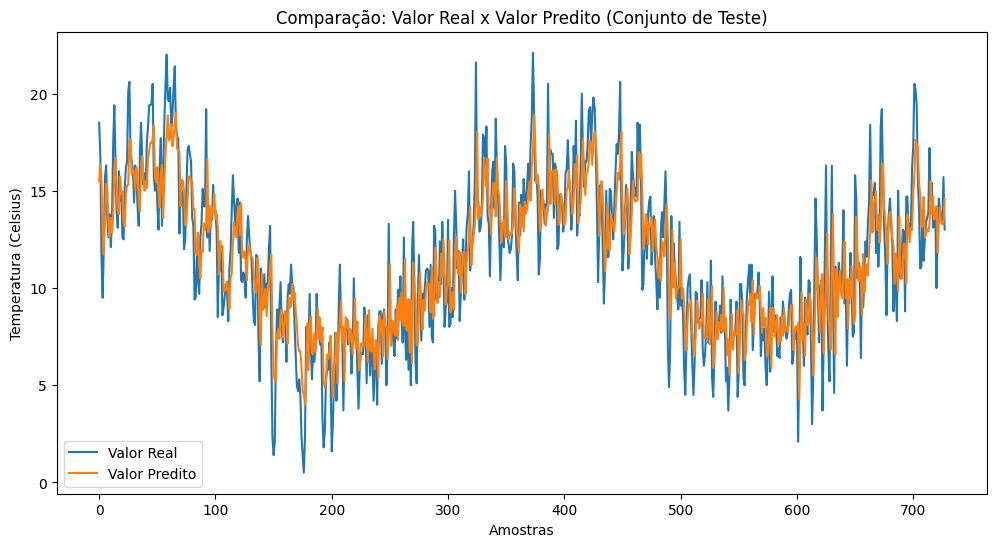

In [ ]:
# 7. Visualização: Gráfico comparando valores reais e preditos para o conjunto de teste
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Valor Real')
plt.plot(test_pred, label='Valor Predito')
plt.title('Comparação: Valor Real x Valor Predito (Conjunto de Teste)')
plt.xlabel('Amostras')
plt.ylabel('Temperatura (Celsius)')
plt.legend()
plt.show()